In [1]:
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
import os, glob
import pandas as pd

# Prepare Data

In [2]:

image_paths = glob.glob(os.path.join('IMG','*.jpg'))
driver_obs = pd.read_csv(os.path.join('driving_log.csv'))

In [3]:
print('Size of images:',len(image_paths))
print('Size of Car Obs:',len(driver_obs))
doc_size = len(driver_obs)
driver_obs.head()

Size of images: 24108
Size of Car Obs: 8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [44]:
print(image_paths[0])
print(image_paths[1])
print(image_paths[2])

IMG\center_2016_12_01_13_30_48_287.jpg
IMG\center_2016_12_01_13_30_48_404.jpg
IMG\center_2016_12_01_13_31_12_937.jpg


In [45]:
driver_obs.iloc[2]['steering']

0.0

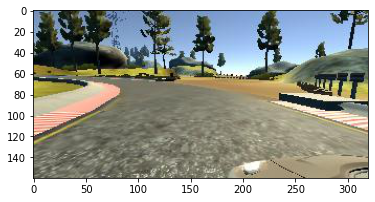

In [46]:
img = plt.imread(driver_obs.iloc[3]['left'].strip(' '))
plt.imshow(img)

In [58]:
from torch.utils.data import Dataset, dataloader
from torchvision import transforms
from PIL import Image, ImageOps

class CustomDataSet(Dataset):
    def __init__(self, data_path, transform ):
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_path)
        
    def __getitem__(self, idx):
        data = driver_obs.iloc[idx]
        c_img = Image.open(data['center'].strip(' '))
        l_img = Image.open(data['left'].strip(' '))
        r_img = Image.open(data['right'].strip(' '))
        c_img, l_img, r_img = ImageOps.grayscale(c_img), ImageOps.grayscale(l_img), ImageOps.grayscale(r_img)
        c_img, l_img, r_img = self.transform(c_img), self.transform(l_img), self.transform(r_img)
#         tensor_img = torch.stack((c_img, l_img, r_img)).squeeze(1)
        return torch.cat((c_img, l_img, r_img)), torch.stack((torch.tensor(data['steering']),
                                       torch.tensor(data['throttle']), 
                                       torch.tensor(data['brake']),
                                       torch.tensor(data['speed'])))
        
def load_data(image_path, batch_size, train=True, shuffle=True ):
    train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485],
                                  std=[0.229])])
    
    test_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485],
                                          std=[0.229])])
    
    trans = train_transform if train else test_transform
    _data = CustomDataSet(driver_obs, trans)
    data_loader = torch.utils.data.DataLoader(_data, batch_size=batch_size, shuffle=shuffle)
    return data_loader

        

In [59]:
import torchvision
import torch.utils.data as data_utils
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_split = int(0.7*doc_size)
valid_split = int(0.2*doc_size)

train = driver_obs.iloc[:train_split]
valid = driver_obs.iloc[train_split: train_split+ valid_split]
test = driver_obs.iloc[train_split+valid_split:]

train_loader = load_data(train, batch_size, True )
valid_loader = load_data(valid, batch_size, True )
test_loader = load_data(test, batch_size, False , False)

In [60]:
t, l = (iter(test_loader).next())

In [61]:
imshape = t.shape
print(imshape)
label_sz = l.shape[1]
print(label_sz)
print(len(t[0]))
t= t.squeeze(2)
print(t.shape)

torch.Size([64, 3, 160, 320])
4
3
torch.Size([64, 3, 160, 320])


# Create Model

In [80]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, out_sz):
        super(Network, self).__init__()
        
        self.conv1 =  nn.Conv2d(3, 24, 5, 1, 2) # (160, 320)
        self.conv2 =  nn.Conv2d(24, 36, 5, 1, 2) # (80, 160)
        self.conv3 =  nn.Conv2d(36, 48, 3, 1, 1) # (40, 80)
        self.conv4 =  nn.Conv2d(48, 64, 3, 1, 1) # (20, 40)
        self.fc1 = nn.Linear(10*20*64, 2000) # (10, 20)
        self.fc2 = nn.Linear(2000, 512)
        self.fc3 = nn.Linear(512, out_sz)
        self.maxpool= nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, images):
        batch_size = images.shape[0]
        x = F.relu(self.maxpool(self.conv1(images)))
        x = self.dropout(x)
        x = F.relu(self.maxpool(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.maxpool(self.conv3(x)))
        x = self.dropout(x)
        x = F.relu(self.maxpool(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(batch_size, -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(label_sz)
model.to(device)
model

Network(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12800, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=4, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
)

#### Test Model

In [66]:
t = t.to(device)
y = model(t)
y.shape

torch.Size([64, 4])

# Train Model

In [71]:
from torch import optim
import numpy as np
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

epochs = 100
steps = 0
best_score = np.inf
improv_stop_gap = 0
model.load_state_dict(torch.load('checkpoint.pth'))
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for x, y in train_loader:
        images = x.to(device)
        labels = y.to(device)
        optimizer.zero_grad()
        y_pred = model(images)
        loss = criterion(y_pred, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for x, y in valid_loader:
                images = x.to(device)
                labels = y.to(device)
                logits = model(images)
                test_loss += criterion(logits, labels.float())
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(valid_loader))
        
        if test_losses[-1] < best_score:
            print("Best Score improved from {} to {} : saved model".format(best_score, test_losses[-1]) )
            best_score = test_losses[-1]
            torch.save(model.state_dict(), 'checkpoint.pth')
            improv_stop_gap = 0
            
        if improv_stop_gap > 10:
            break
            
        improv_stop_gap += 1
            
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]))

Best Score improved from inf to 0.5841662287712097 : saved model
Epoch: 1/100..  Training Loss: 0.950..  Test Loss: 0.584.. 
Epoch: 2/100..  Training Loss: 1.133..  Test Loss: 1.733.. 
Epoch: 3/100..  Training Loss: 0.999..  Test Loss: 1.562.. 
Epoch: 4/100..  Training Loss: 1.058..  Test Loss: 2.426.. 
Epoch: 5/100..  Training Loss: 0.935..  Test Loss: 1.646.. 
Epoch: 6/100..  Training Loss: 0.905..  Test Loss: 3.637.. 
Epoch: 7/100..  Training Loss: 0.965..  Test Loss: 3.975.. 


KeyboardInterrupt: 

In [ ]:
t_loss = 0
with torch.no_grad():
    model.eval()
    for x, y in test_loader:
        images = x.to(device)
        labels = y.to(device)
        logits = model(images)
        t_loss += criterion(logits, labels.float())
print('TestLoss:', t_loss/len(test_loader))

In [81]:
model.load_state_dict(torch.load('checkpoint.pth'))
torch.onnx.export(model, t, "p_model.onnx")